## Quantium Virtual Internship - Retail Strategy and Analytics 
### Experimentation and uplift testing 
- 1. Analyse store performances
- 2. Select the right control store for each trial store 
- 3. Analyse the performance differences for control/trial 
    - Use corelation 
    - Combo of metrics 

In [1]:
# Import modules 
import pandas as pd
import numpy as np 
import os
from datetime import datetime
import xlrd
import matplotlib.pyplot as plt
import warnings
import researchpy as rp
import scipy.stats as stats
warnings.filterwarnings('ignore')
%run ./layout_analysis.ipynb

In [2]:
# Load data
DATA_DIR = os.path.join('..','Quantium')
QVI_DATA = os.path.join(DATA_DIR,'QVI_data.csv')
qvi_data = pd.read_csv(QVI_DATA, parse_dates=['DATE'])

In [3]:
%matplotlib inline

### Select control stores

The client has selected store numbers 77, 86 and 88 as trial stores and want control stores to be established
stores that are operational for the entire observation period.
We would want to match trial stores to control stores that are similar to the trial store prior to the trial period
of Feb 2019 in terms of :

- Monthly overall sales revenue
- Monthly number of customers
- Monthly number of transactions per customer

**Let’s first create the metrics of interest and filter to stores that are present throughout the pre-trial period**

In [4]:
# Create new column for month and filter out all the stores has less than 12 months observations 
qvi_data['month'] = pd.DatetimeIndex(qvi_data['DATE']).month
qvi_data['y_m'] = qvi_data.DATE.dt.to_period('M')
list_store = qvi_data.groupby('STORE_NBR').month.nunique().to_frame().query('month == 12').index.to_list()
clean_data = qvi_data.loc[qvi_data.STORE_NBR.isin(list_store)].copy()

In [5]:
# Calculate total sales revenue by store per month
m_sales_p_store = clean_data.groupby(['STORE_NBR','y_m']).TOT_SALES.sum().to_frame()

# Calculate total number of unique customer by store per month
m_customer_p_store = clean_data.groupby(['STORE_NBR','y_m']).LYLTY_CARD_NBR.nunique().to_frame()

# Calculate average number of transaction by store per month
m_customer_transaction_p_store = (clean_data.groupby(['STORE_NBR','y_m']).\
    LYLTY_CARD_NBR.count()/clean_data.groupby(['STORE_NBR','y_m']).LYLTY_CARD_NBR.nunique()).to_frame()

#### Next steps 
Now we need to work out a way of ranking how similar each potential control store is to the trial store. 

We can calculate how correlated the performance of each store is to the trial store.

Let’s use a UDF function for this so that we don’t have to calculate this for each trial store and control store pair.

Apart from correlation, we can also calculate a standardised metric based on the absolute difference between the trial store’s performance and each control store’s performance.

#### Next steps:
Now let’s use the functions to find the control stores!

We’ll select control stores based on how similar `monthly total sales` in dollar amounts and `monthly number of customers` are to the trial stores. So we will need to use our functions to get four scores, two for each of total sales and total customers.

## Store 77 analysis:

In [6]:
pre_df_sales = m_sales_p_store.reset_index().query('y_m < "2019-02"')
pre_df_customer = m_customer_p_store.reset_index().query('y_m < "2019-02"')

In [7]:
# Calculate correlation 
score_sales = calculateCorrelation(list_store, pre_df_sales,77,'TOT_SALES')
score_customer = calculateCorrelation(list_store, pre_df_customer,77,'LYLTY_CARD_NBR')

# Calculate distance 
dis_sales = calculateMagnitudeDistance(list_store, pre_df_sales,77,'TOT_SALES')
dis_customer = calculateMagnitudeDistance(list_store, pre_df_customer,77,'LYLTY_CARD_NBR')

#### Next steps:
We’ll need to combine all the scores to create a composite score to rank on.

Let’s take a simple average of the correlation and magnitude scores for each driver. Note that if we consider it more important for the trend of the drivers to be similar, we can increase the weight of the correlation score (a simple average gives a weight of 0.5 to the corr_weight) or if we consider the absolute size of the drivers to be more important, we can lower the weight of the correlation score.

In [8]:
# Final the store with highest score to be the control store, which is store 233
control_store = calculateFinalScore(score_sales,dis_sales,score_customer,dis_customer)
control_store

,store,score
221,233.0,0.756949


#### Observation:
The store with the highest score is then selected as the control store since it is most similar to the trial store, which is **store 233**.  

#### Next step:
Now that we have found a control store, let’s check visually if the drivers are indeed similar in the period before the trial.

##### We’ll look at total sales first. 

In [33]:
%run ./layout_analysis.ipynb

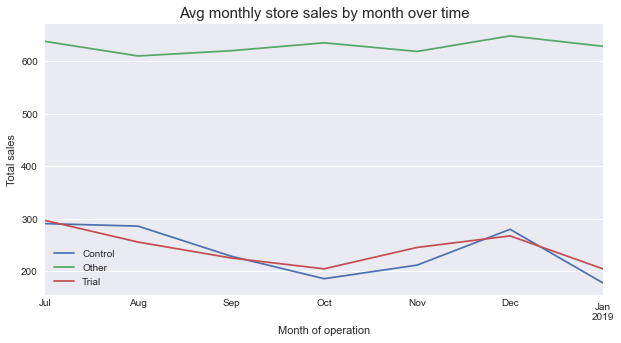

In [34]:
# Plot total sales by month 
flat_sales = createType(m_sales_p_store, 77, 233)
plot_m_data(flat_sales,'TOT_SALES','sales')

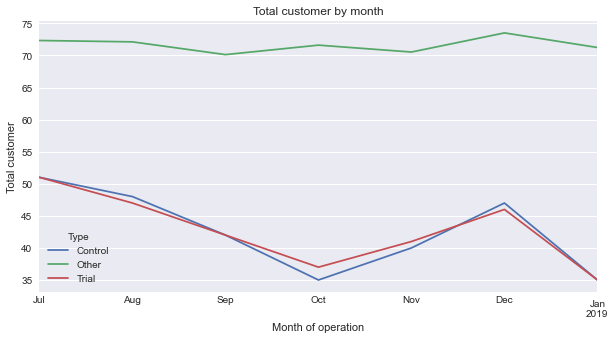

In [10]:
# Plot customer number by month 
flat_customer = createType(m_customer_p_store, 77,233)
plot_m_data(flat_customer,'LYLTY_CARD_NBR','customer')

### Assessment of trial stores
The trial period goes from the start of March 2019 to June 2019. We now want to see if there has been an uplift in overall chip sales.

##### We’ll start with scaling the control store’s sales to a level similar to control for any differences between the two stores outside of the trial period.

Now that we have comparable sales figures for the control store, we can calculate the percentage difference
between the scaled control sales and the trial store’s sales during the trial period.

In [11]:
merge_whole = scaleAndCalculatePctDiff(flat_sales,m_sales_p_store, 77, 233, 'TOT_SALES')

#### Next step
 
Let’s see if the difference is significant!

In [12]:
# As our null hypothesis is that the trial period is the same as the pre‐trial period, let's take the standard 
# deviation based on the scaled percentage difference in the pre‐trial period
std_pre_trial = merge_whole.query('y_m < "2019-02"').pctDiff.std()

# note that there are 7 months in the pre‐trial period hence 7 ‐ 1 = 6 degrees of freedom
degreesOfFreedom = 6

# We will test with a null hypothesis of there being 0 difference between trial and control stores
(merge_whole.query('y_m > "2019-01" and y_m < "2019-05"').pctDiff - 0)/std_pre_trial

7     1.183534
8     7.339116
9    12.476373
Name: pctDiff, dtype: float64

#### The 95th percentile of the t distribution with the appropriate degrees of freedom is  1.894579 

#### Observation 
We can observe that the t-value is much larger than the 95th percentile value of the t-distribution for March
and April - i.e. the increase in sales in the trial store in March and April is statistically greater than in the
control store.

#### Next step
Let’s create a more visual version of this by plotting the sales of the control store, the sales of the trial stores
and the 95th percentile value of sales of the control store.

In [36]:
# Add 95% and 5% interval data 
trial_data = m_sales_p_store.reindex().query('STORE_NBR == 77')
control_data = m_sales_p_store.reindex().query('STORE_NBR == 233')
df_with_conf_interval = add_95_5_data(trial_data, std_pre_trial, control_data, 'TOT_SALES')

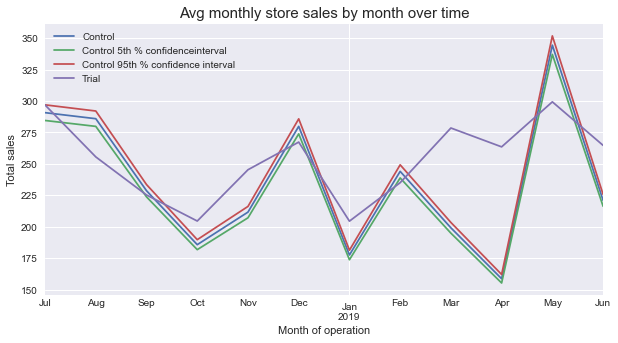

In [37]:
# Plot monthly sales for control, trial stores with 95% and 5% confident inverval 
plot_m_data(df_with_conf_interval, 'TOT_SALES','sales')

#### Observation 
The results show that the trial in store 77 is significantly different to its control store in the trial period as
the trial store performance lies outside the 5% to 95% confidence interval of the control store in two of the
three trial months.

#### Next step
Let’s have a look at assessing this for number of customers as well.

In [15]:
test = scaleAndCalculatePctDiff(flat_customer,m_customer_p_store, 77, 233, 'LYLTY_CARD_NBR')

#### Next step 

Let’s again see if the difference is significant visually!

In [16]:
test = scaleAndCalculatePctDiff(flat_customer,m_customer_p_store, 77, 233, 'LYLTY_CARD_NBR')

# As our null hypothesis is that the trial period is the same as the pre‐trial period, let's take the standard 
# deviation based on the scaled percentage difference in the pre‐trial period
std_pre_trial = test.query('y_m < "2019-02"').pctDiff.std()

# note that there are 7 months in the pre‐trial period hence 7 ‐ 1 = 6 degrees of freedom
degreesOfFreedom = 6

# We will test with a null hypothesis of there being 0 difference between trial and control stores
(test.query('y_m > "2019-01" and y_m < "2019-05"').pctDiff - 0)/std_pre_trial

7     6.053553
8     3.026777
9    14.528527
Name: pctDiff, dtype: float64

#### Next step
Let’s create a more visual version of this by plotting the customer number of the control store,  trial stores and the 95th, 5th percentile value of the control store

In [17]:
# Add 95% and 5% interval data 
trial_data = m_customer_p_store.reindex().query('STORE_NBR == 77')
control_data = m_customer_p_store.reindex().query('STORE_NBR == 233')
df_with_conf_interval = add_95_5_data(trial_data, std_pre_trial, control_data, 'LYLTY_CARD_NBR')

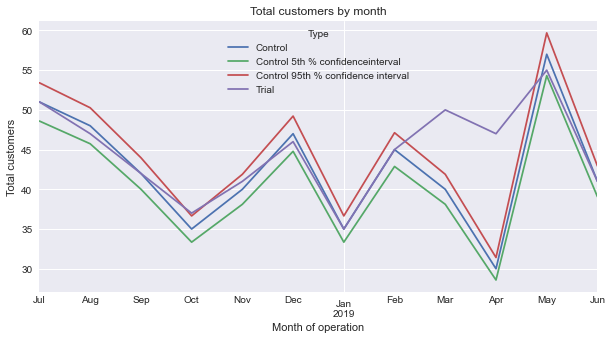

In [18]:
# Plot monthly sales for control, trial stores with 95% and 5% confident inverval 
plot_m_data(df_with_conf_interval, 'LYLTY_CARD_NBR','customers')

#### Let’s repeat finding the control store and assessing the impact of the trial for each of the other two trial stores.

### Trial store 86 

In [19]:
# Calculate correlation 
score_sales = calculateCorrelation(list_store, pre_df_sales,86,'TOT_SALES')
score_customer = calculateCorrelation(list_store, pre_df_customer,86,'LYLTY_CARD_NBR')

# Calculate distance 
dis_sales = calculateMagnitudeDistance(list_store, pre_df_sales,86,'TOT_SALES')
dis_customer = calculateMagnitudeDistance(list_store, pre_df_customer,86,'LYLTY_CARD_NBR')

In [20]:
# Final the store with highest score to be the control store, which is store 233
control_store = calculateFinalScore(score_sales,dis_sales,score_customer,dis_customer)
control_store

,store,score
147,155.0,0.770724


#### Observation:

The store with the highest score is then selected as the control store since it is most similar to the trial store, which is store 155.

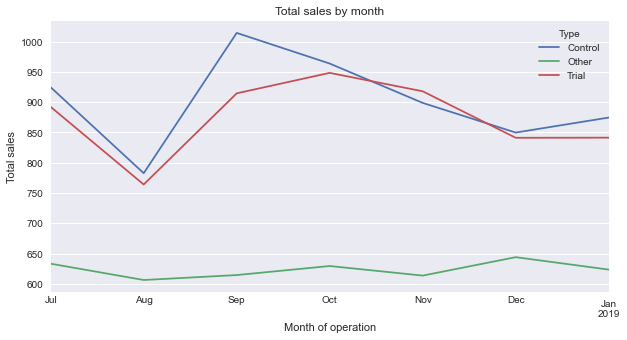

In [21]:
# Plot total sales by month 
flat_sales = createType(m_sales_p_store, 86, 155)
plot_m_data(flat_sales,'TOT_SALES','sales')

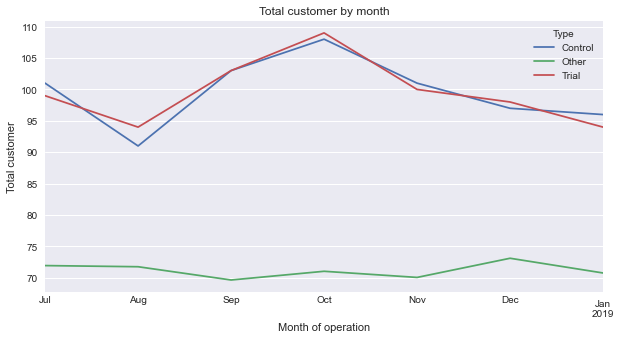

In [22]:
# Plot customer number by month 
flat_customer = createType(m_customer_p_store, 86,155)
plot_m_data(flat_customer,'LYLTY_CARD_NBR','customer')

### Assessment of trial stores

In [23]:
merge_whole = scaleAndCalculatePctDiff(flat_sales,m_sales_p_store, 86, 155, 'TOT_SALES')

In [24]:
# As our null hypothesis is that the trial period is the same as the pre‐trial period, let's take the standard 
# deviation based on the scaled percentage difference in the pre‐trial period
std_pre_trial = merge_whole.query('y_m < "2019-02"').pctDiff.std()

# note that there are 7 months in the pre‐trial period hence 7 ‐ 1 = 6 degrees of freedom
degreesOfFreedom = 6

# We will test with a null hypothesis of there being 0 difference between trial and control stores
(merge_whole.query('y_m > "2019-01" and y_m < "2019-05"').pctDiff - 0)/std_pre_trial

7     2.179542
8    12.226922
9     1.364580
Name: pctDiff, dtype: float64

#### The 95th percentile of the t distribution with the appropriate degrees of freedom is 1.894579

#### Observation

We can observe that the t-value is much larger than the 95th percentile value of the t-distribution for Feburary and March - i.e. the increase in sales in the trial store in Feburary and March is statistically greater than in the control store.


#### Next step

Let’s create a more visual version of this by plotting the sales of the control store, the sales of the trial stores and the 95th percentile value of sales of the control store.

In [25]:
# Add 95% and 5% interval data 
trial_data = m_sales_p_store.reindex().query('STORE_NBR == 86')
control_data = m_sales_p_store.reindex().query('STORE_NBR == 155')
df_with_conf_interval = add_95_5_data(trial_data, std_pre_trial, control_data, 'TOT_SALES')

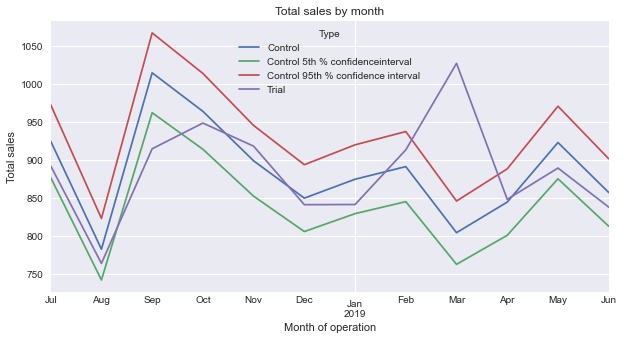

In [26]:
# Plot monthly sales for control, trial stores with 95% and 5% confident inverval 
plot_m_data(df_with_conf_interval, 'TOT_SALES','sales')

#### Observation

The results show that the trial in store 86 is significantly different to its control store in the trial period as the trial store performance lies outside the 5% to 95% confidence interval of the control store in two of the three trial months.

#### Next step

Let’s have a look at assessing this for number of customers as well.

In [27]:
store_86 = scaleAndCalculatePctDiff(flat_customer,m_customer_p_store, 86, 155, 'LYLTY_CARD_NBR')

# As our null hypothesis is that the trial period is the same as the pre‐trial period, let's take the standard 
# deviation based on the scaled percentage difference in the pre‐trial period
std_pre_trial = store_86.query('y_m < "2019-02"').pctDiff.std()

# note that there are 7 months in the pre‐trial period hence 7 ‐ 1 = 6 degrees of freedom
degreesOfFreedom = 6

# We will test with a null hypothesis of there being 0 difference between trial and control stores
(store_86.query('y_m > "2019-01" and y_m < "2019-05"').pctDiff - 0)/std_pre_trial

7    11.819082
8    20.903430
9     5.670772
Name: pctDiff, dtype: float64

In [28]:
# Add 95% and 5% interval data 
trial_data = m_customer_p_store.reindex().query('STORE_NBR == 86')
control_data = m_customer_p_store.reindex().query('STORE_NBR == 155')
df_with_conf_interval = add_95_5_data(trial_data, std_pre_trial, control_data, 'LYLTY_CARD_NBR')

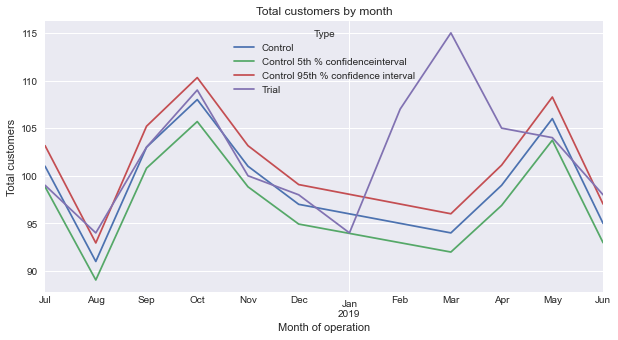

In [29]:
# Plot monthly sales for control, trial stores with 95% and 5% confident inverval 
plot_m_data(df_with_conf_interval, 'LYLTY_CARD_NBR','customers')